In [1]:
import os
import datetime
import time
from IPython.display import clear_output

import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.loader.dataloader import DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from ClusterDataset import ClusterDataset
from training import *
from data_statistics import *

from GNN_TrackLinkingNet import GNN_TrackLinkingNet, FocalLoss, EarlyStopping, weight_init

from IPython.display import display

2025-05-15 12:14:21.142987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747304061.159974     674 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747304061.164939     674 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-15 12:14:21.185652: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load the dataset
hist_folder = "/eos/user/c/czeh/histo_new/"
data_folder_training = "/eos/user/c/czeh/graph_data"
data_folder_test = "/eos/user/c/czeh/graph_data_test"

model_folder = "/eos/user/c/czeh/model"
dataset_training = ClusterDataset(data_folder_training, hist_folder)
dataset_test = ClusterDataset(data_folder_test, hist_folder, test=True)

In [4]:
print_dataset_statistics(dataset_training)

Number of events in training dataset: 299


/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{

Number of nodes: 8710
Mean Number of nodes: 29.130434782608695
Number of edges: 53836
Mean Number of edges: 180.05351170568562
Number of positive edges: 47377
Mean Number of positive edges: 158.45150756835938
Number of negative edges: 6459
Mean Number of negative edges: 21.602006912231445


In [5]:
print_dataset_statistics(dataset_test)

Number of events in training dataset: 100
Number of nodes: 2891
Mean Number of nodes: 28.91
Number of edges: 17805
Mean Number of edges: 178.05
Number of positive edges: 15627
Mean Number of positive edges: 156.27000427246094
Number of negative edges: 2178
Mean Number of negative edges: 21.780000686645508


In [6]:
train_dl = DataLoader(dataset_training, shuffle=True)
test_dl = DataLoader(dataset_test, shuffle=True)

In [7]:
epochs = 200
start_epoch = 0

model = GNN_TrackLinkingNet(input_dim = dataset_training.get(0).x.shape[1], 
                                edge_feature_dim=dataset_training.get(0).edges_features.shape[1],
                                edge_hidden_dim=16, hidden_dim=16, weighted_aggr=True,
                               dropout=0.3)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)
loss_obj = FocalLoss(alpha=0.45, gamma=2)
early_stopping = EarlyStopping()

model.apply(weight_init)

# weights = torch.load(model_folder + "/model_epoch_100_loss_26.8352_2025-05-13.pt", weights_only=True)
# model.load_state_dict(weights["model_state_dict"])
# optimizer.load_state_dict(weights["optimizer_state_dict"])
# start_epoch = weights["epoch"]

GNN_TrackLinkingNet(
  (inputnetwork): Sequential(
    (0): Linear(in_features=29, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (edge_inputnetwork): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (attention_direct): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=1, bias=True)
    (4): Sigmoid()
  )
  (attention_reverse): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)


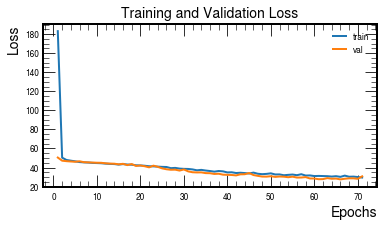

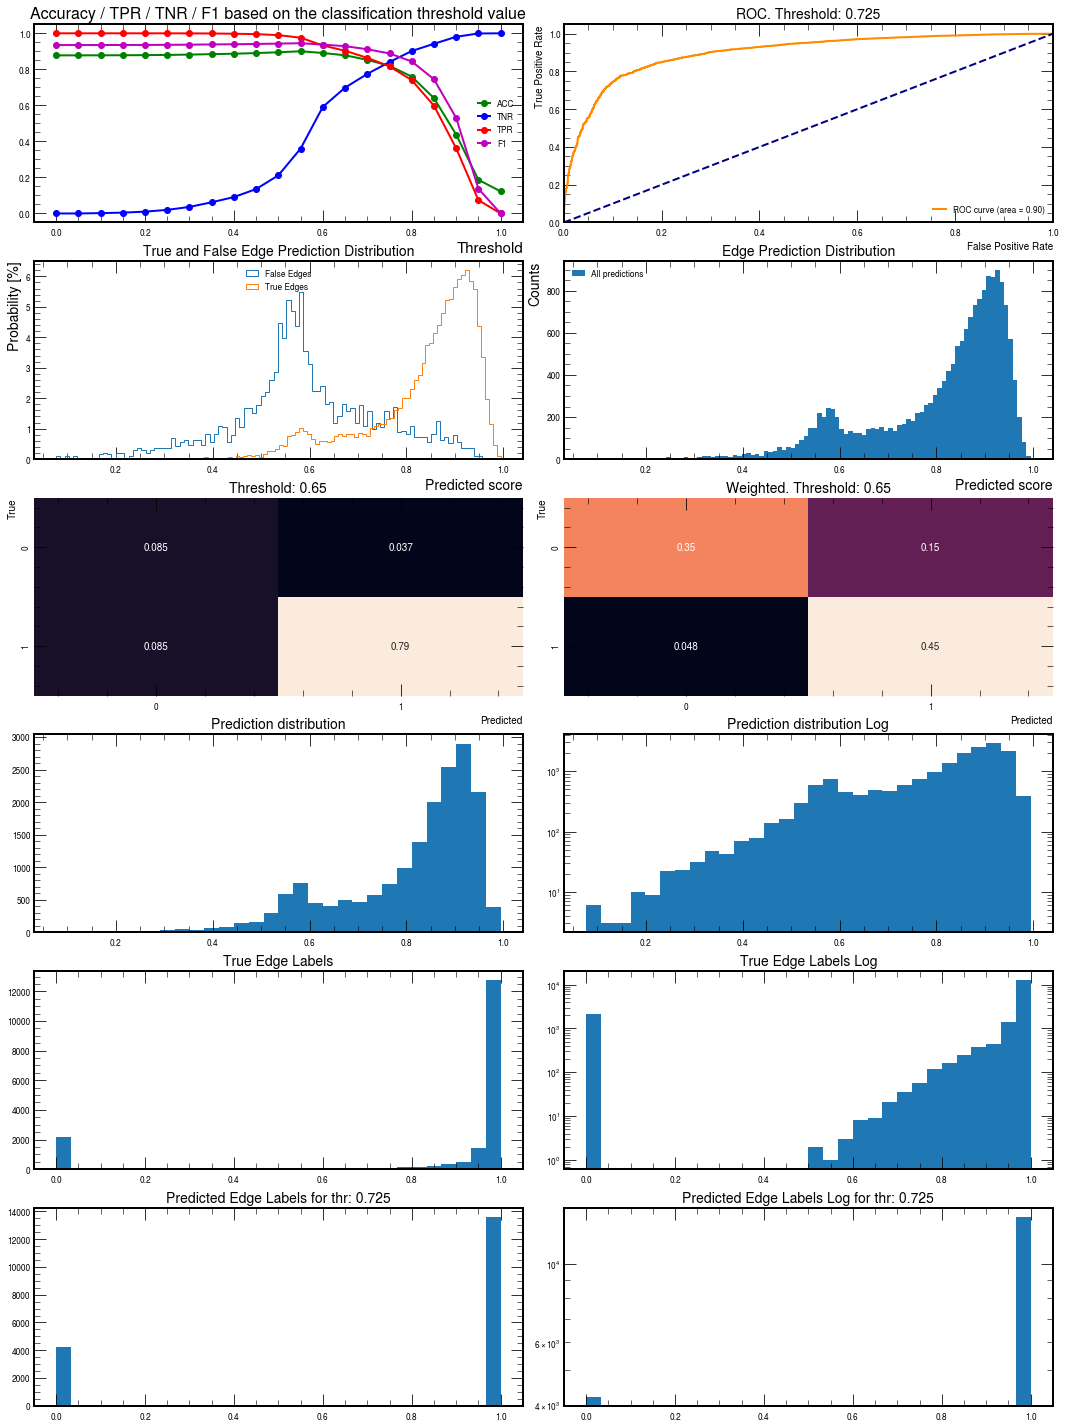

Epoch: 1


Training epoch 1: 100%|██████████| 299/299 [00:06<00:00, 45.07it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 94.89it/s]


Epoch: 2


Training epoch 2: 100%|██████████| 299/299 [00:04<00:00, 60.71it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 91.42it/s]


Epoch: 3


Training epoch 3: 100%|██████████| 299/299 [00:05<00:00, 58.84it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 91.16it/s]


Epoch: 4


Training epoch 4: 100%|██████████| 299/299 [00:05<00:00, 57.15it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 74.04it/s]


Epoch: 5


Training epoch 5: 100%|██████████| 299/299 [00:05<00:00, 57.97it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 90.25it/s]


Epoch: 6


Training epoch 6: 100%|██████████| 299/299 [00:05<00:00, 58.78it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 90.52it/s]


Epoch: 7


Training epoch 7: 100%|██████████| 299/299 [00:05<00:00, 59.47it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 82.20it/s]


Epoch: 8


Training epoch 8: 100%|██████████| 299/299 [00:05<00:00, 57.89it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 84.65it/s]


Epoch: 9


Training epoch 9: 100%|██████████| 299/299 [00:05<00:00, 56.97it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 88.12it/s]


Epoch: 10


Training epoch 10: 100%|██████████| 299/299 [00:04<00:00, 61.76it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 90.18it/s]


Epoch: 11


Training epoch 11: 100%|██████████| 299/299 [00:05<00:00, 51.51it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 75.15it/s]


Epoch: 12


Training epoch 12: 100%|██████████| 299/299 [00:05<00:00, 51.99it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 69.45it/s]


Epoch: 13


Training epoch 13: 100%|██████████| 299/299 [00:06<00:00, 48.42it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 87.47it/s]


Epoch: 14


Training epoch 14: 100%|██████████| 299/299 [00:05<00:00, 57.42it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 89.48it/s]


Epoch: 15


Training epoch 15: 100%|██████████| 299/299 [00:05<00:00, 58.05it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 88.71it/s]


Epoch: 16


Training epoch 16: 100%|██████████| 299/299 [00:05<00:00, 56.65it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 84.14it/s]


Epoch: 17


Training epoch 17: 100%|██████████| 299/299 [00:05<00:00, 59.44it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 94.68it/s]


Epoch: 18


Training epoch 18: 100%|██████████| 299/299 [00:04<00:00, 60.30it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 95.41it/s]


Epoch: 19


Training epoch 19: 100%|██████████| 299/299 [00:04<00:00, 60.17it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 89.33it/s]


Epoch: 20


Training epoch 20: 100%|██████████| 299/299 [00:05<00:00, 59.67it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 89.64it/s]


Epoch: 20
Scores for Classification with Threshold: 0.625.
F1 score: 0.840
Balanced Accuracy: 0.661
Accuracy: 0.743
Precision: 92.4988
Recall: 76.9374
Negative predictive value: 25.0260
True negative rate: 55.2342
Precision Weighted: [0.70544587 0.63217201]
Recall Weighted: [0.5523416  0.76937352]
F1 score Weighted: [0.61957542 0.69405723]
Positive Likelihood Ratio: 1.7186620789462026
Negative Likelihood Ratio: 0.4175432028490877
Epoch: 21


Training epoch 21:   0%|          | 0/299 [00:00<?, ?it/s]/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 85.75it/s]


Epoch: 22


Training epoch 28: 100%|██████████| 299/299 [00:05<00:00, 58.37it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 93.45it/s]


Epoch: 29


Training epoch 29: 100%|██████████| 299/299 [00:05<00:00, 59.65it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 93.67it/s]


Epoch: 30


Training epoch 30: 100%|██████████| 299/299 [00:05<00:00, 58.84it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 90.11it/s]


Epoch: 31


Training epoch 31: 100%|██████████| 299/299 [00:05<00:00, 58.51it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 87.66it/s]


Epoch: 32


Training epoch 32: 100%|██████████| 299/299 [00:05<00:00, 59.06it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 96.15it/s]


Epoch: 33


Training epoch 33: 100%|██████████| 299/299 [00:05<00:00, 58.31it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 90.99it/s]


Epoch: 34


Training epoch 34: 100%|██████████| 299/299 [00:04<00:00, 59.85it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 89.66it/s]


Epoch: 35


Training epoch 35: 100%|██████████| 299/299 [00:05<00:00, 59.15it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 88.42it/s]


Epoch: 36


Training epoch 36: 100%|██████████| 299/299 [00:05<00:00, 58.91it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 90.21it/s]


Epoch: 37


Training epoch 37: 100%|██████████| 299/299 [00:04<00:00, 59.90it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 92.73it/s]


Epoch: 38


Training epoch 38: 100%|██████████| 299/299 [00:04<00:00, 60.29it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 90.48it/s]


Epoch: 39


Training epoch 39: 100%|██████████| 299/299 [00:05<00:00, 57.80it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 89.15it/s]


Epoch: 40


Training epoch 40: 100%|██████████| 299/299 [00:05<00:00, 57.48it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 89.94it/s]


Epoch: 40
Scores for Classification with Threshold: 0.65.
F1 score: 0.876
Balanced Accuracy: 0.799
Accuracy: 0.801
Precision: 96.5839
Recall: 80.1497
Negative predictive value: 35.8693
True negative rate: 79.6602
Precision Weighted: [0.80052095 0.79759317]
Recall Weighted: [0.79660239 0.80149741]
F1 score Weighted: [0.79855686 0.79954052]
Positive Likelihood Ratio: 3.940544820195295
Negative Likelihood Ratio: 0.2491865387051783
Epoch: 41


Training epoch 41:   0%|          | 0/299 [00:00<?, ?it/s]/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 91.13it/s]


Epoch: 42


Training epoch 42: 100%|██████████| 299/299 [00:05<00:00, 59.40it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 90.86it/s]


Epoch: 43


Training epoch 43: 100%|██████████| 299/299 [00:04<00:00, 59.82it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 92.48it/s]


Epoch: 44


Training epoch 44: 100%|██████████| 299/299 [00:04<00:00, 60.83it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 85.35it/s]


Epoch: 45


Training epoch 45: 100%|██████████| 299/299 [00:05<00:00, 59.23it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 93.35it/s]


Epoch: 46


Training epoch 46: 100%|██████████| 299/299 [00:05<00:00, 59.54it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 91.46it/s]


Epoch: 47


Training epoch 47: 100%|██████████| 299/299 [00:04<00:00, 60.00it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 94.79it/s]


Epoch: 48


Training epoch 48: 100%|██████████| 299/299 [00:05<00:00, 59.56it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 91.13it/s]


Epoch: 49


Training epoch 49: 100%|██████████| 299/299 [00:05<00:00, 57.19it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 83.55it/s]


Epoch: 50


Training epoch 50: 100%|██████████| 299/299 [00:05<00:00, 58.33it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 90.92it/s]


Epoch: 51


Training epoch 51: 100%|██████████| 299/299 [00:05<00:00, 56.61it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 84.77it/s]


Epoch: 52


Training epoch 52: 100%|██████████| 299/299 [00:05<00:00, 56.21it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 70.27it/s]


Epoch: 53


Training epoch 53: 100%|██████████| 299/299 [00:06<00:00, 48.34it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 65.99it/s]


Epoch: 54


Training epoch 54: 100%|██████████| 299/299 [00:06<00:00, 48.19it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 67.04it/s]


Epoch: 55


Training epoch 55: 100%|██████████| 299/299 [00:06<00:00, 48.48it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 72.72it/s]


Epoch: 56


Training epoch 56: 100%|██████████| 299/299 [00:05<00:00, 58.92it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 90.38it/s]


Epoch: 57


Training epoch 57: 100%|██████████| 299/299 [00:05<00:00, 55.90it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 80.00it/s]


Epoch: 58


Training epoch 58: 100%|██████████| 299/299 [00:05<00:00, 55.32it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 86.42it/s]


Epoch: 59


Training epoch 59: 100%|██████████| 299/299 [00:05<00:00, 56.74it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 84.43it/s]


Epoch: 60


Training epoch 60: 100%|██████████| 299/299 [00:05<00:00, 55.96it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 91.46it/s]


Epoch: 60
Scores for Classification with Threshold: 0.675.
F1 score: 0.896
Balanced Accuracy: 0.827
Accuracy: 0.830
Precision: 97.1285
Recall: 83.1190
Negative predictive value: 40.4783
True negative rate: 82.3691
Precision Weighted: [0.82991428 0.82500361]
Recall Weighted: [0.82369146 0.83118961]
F1 score Weighted: [0.82679116 0.82808506]
Positive Likelihood Ratio: 4.714403556344788
Negative Likelihood Ratio: 0.20494372038104874
>>> Saving model to /eos/user/c/czeh/model/epoch_60_date_2025-05-15_loss_31.0405.pt
Epoch: 61


Training epoch 61:   0%|          | 0/299 [00:00<?, ?it/s]/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 81.67it/s]


Epoch: 62


Training epoch 62:  78%|███████▊  | 233/299 [00:03<00:01, 58.55it/s]

Epoch: 63


Training epoch 63: 100%|██████████| 299/299 [00:05<00:00, 57.74it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 85.03it/s]


Epoch: 64


Training epoch 64: 100%|██████████| 299/299 [00:05<00:00, 57.03it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 87.96it/s]


Epoch: 65


Training epoch 65: 100%|██████████| 299/299 [00:05<00:00, 57.18it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 79.01it/s]


Epoch: 66


Training epoch 66: 100%|██████████| 299/299 [00:05<00:00, 56.34it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 87.72it/s]


Epoch: 67


Training epoch 67: 100%|██████████| 299/299 [00:05<00:00, 55.96it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 84.62it/s]


Epoch: 68


Training epoch 68: 100%|██████████| 299/299 [00:05<00:00, 58.26it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 87.48it/s]


Epoch: 69


Training epoch 69: 100%|██████████| 299/299 [00:05<00:00, 56.46it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 83.94it/s]


Epoch: 70


Training epoch 70: 100%|██████████| 299/299 [00:05<00:00, 56.65it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 85.79it/s]


Epoch: 71


Training epoch 71: 100%|██████████| 299/299 [00:05<00:00, 57.25it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 85.91it/s]


Early stopping after 71 epochs
Scores for Classification with Threshold: 0.725.
F1 score: 0.902
Balanced Accuracy: 0.827
Accuracy: 0.839
Precision: 96.9759
Recall: 84.3412
Negative predictive value: 41.9317
True negative rate: 81.1295
Precision Weighted: [0.83821598 0.81716687]
Recall Weighted: [0.81129477 0.84341204]
F1 score Weighted: [0.82453569 0.83008206]
Positive Likelihood Ratio: 4.469468200041198
Negative Likelihood Ratio: 0.1930099432841357


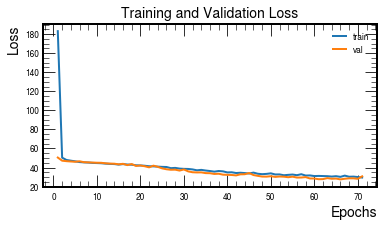

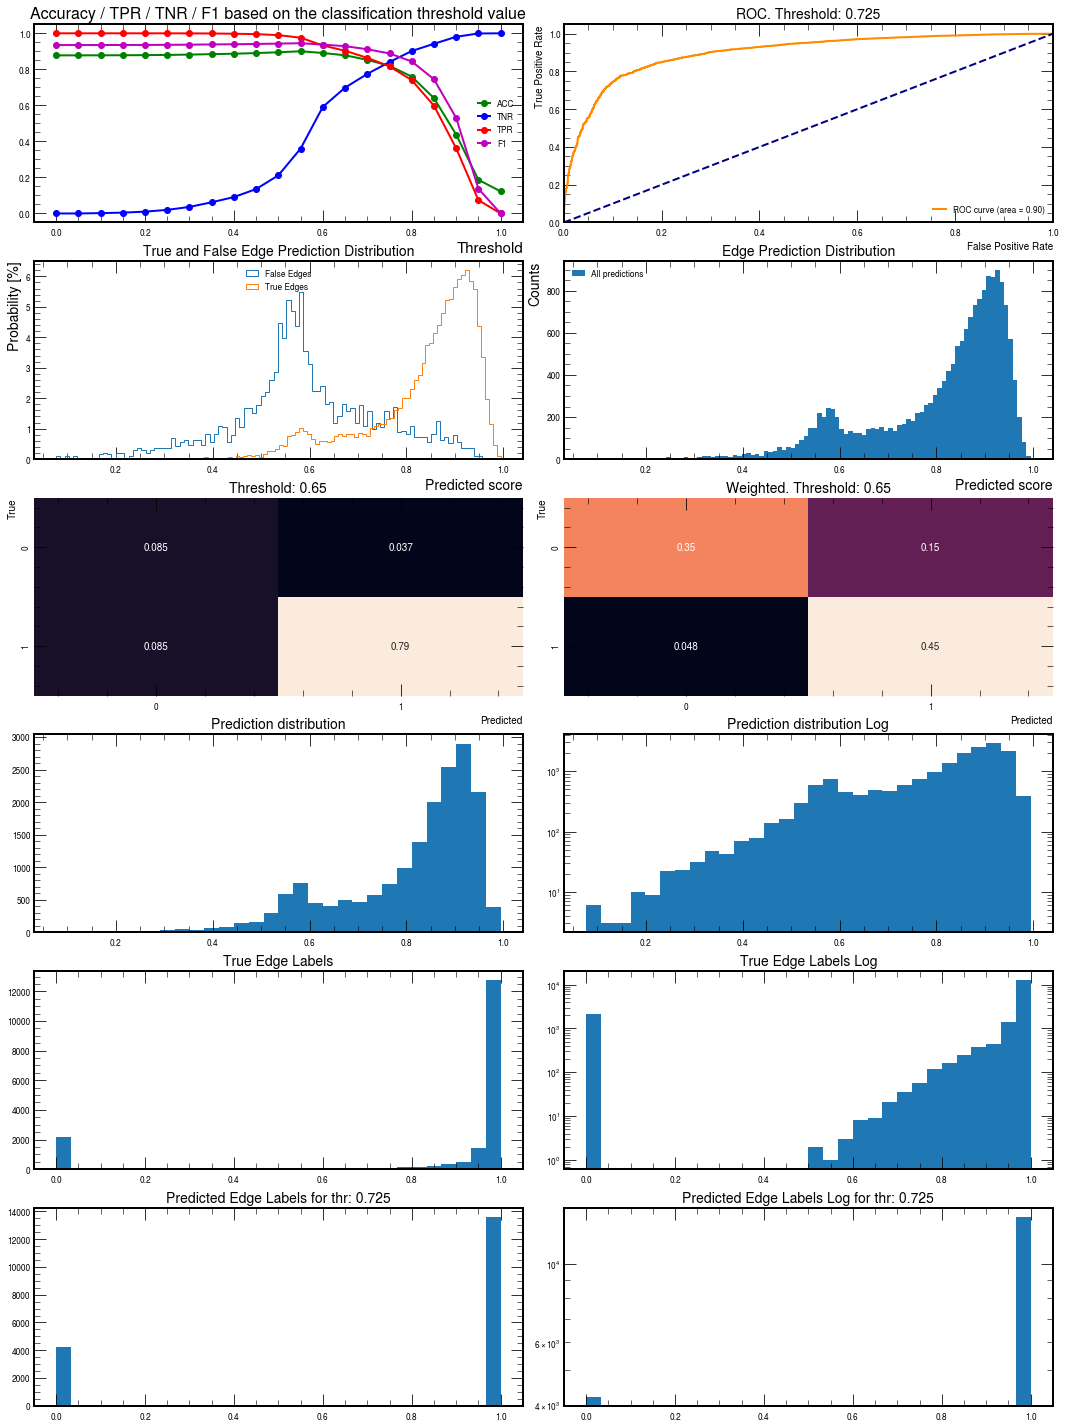

In [8]:
# decision_th = 0.5
os.makedirs(model_folder, exist_ok=True)

train_loss_hist = []
val_loss_hist = []
edge_features = True
date = f"{datetime.now():%Y-%m-%d}"

fig_loss, ax_loss = plt.subplots(1, 1)
fig_loss.set_figwidth(6)
fig_loss.set_figheight(3)

fig_analysis, ax_analysis = plt.subplots(6, 2)
fig_analysis.set_figwidth(15)
fig_analysis.set_figheight(20)
fig_analysis.tight_layout(pad=2.0)

display_loss = display(1, display_id=True)
display_analysis = display(2, display_id=True)

for epoch in range(start_epoch, epochs):
    print(f'Epoch: {epoch+1}')
    
    loss = train(model, optimizer, train_dl, epoch+1, device=device, edge_features=edge_features, loss_obj=loss_obj)
    train_loss_hist.append(loss)
    
    val_loss, pred, y = test(model, test_dl, epoch+1, loss_obj=loss_obj, edge_features=edge_features, device=device)
    val_loss_hist.append(val_loss)
    
    ax_loss.clear()
    plot_loss(train_loss_hist, val_loss_hist, ax=ax_loss)
    display_loss.update(fig_loss)
    time.sleep(1)
    
    early_stopping(model, val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping after {epoch+1} epochs")
        early_stopping.load_best_model(model)
        
        for axes in ax_analysis:
            for ax in axes:
                ax.clear()
            
        plot_validation_results(pred, y, save=True, ax=ax_analysis, output_folder=model_folder, file_suffix=f"epoch_{epoch+1}_date_{date}")
        display_analysis.update(fig_analysis)
        time.sleep(1)
        break
      
    if ((epoch+1)%60==0 or epoch+1==epochs):
        print(f'Epoch: {epoch+1}')
        
        for axes in ax_analysis:
            for ax in axes:
                ax.clear()
            
        plot_validation_results(pred, y, save=True, ax=ax_analysis, output_folder=model_folder, file_suffix=f"epoch_{epoch+1}_date_{date}")
        display_analysis.update(fig_analysis)
        time.sleep(1)
        
        save_model(model, epoch, optimizer, loss, val_loss, output_folder=model_folder, filename=f"epoch_{epoch+1}_date_{date}_loss_{loss:.4f}.pt")
    elif ((epoch+1)%20==0):
        print(f'Epoch: {epoch+1}')
        
        for axes in ax_analysis:
            for ax in axes:
                ax.clear()
        plot_validation_results(pred, y, save=False, ax=ax_analysis) 
        display_analysis.update(fig_analysis)
        time.sleep(1)

    scheduler.step() 